One deliverable of our web app is to predict wine styles that fit the user's tastes. This is useful in case a store does not carry the specific wines that the recommender suggests. To this end, we explore classification algorithms to predict wine styles.

We define a style as a combination between grape variety and a geographic location. However, since most wines in our datasest come from the US, in particular California and Oregon, we define style as follows:

    - grape variety x country for wines from outside the US
    - grape variety x province (state) for wines from the US, except for California and Oregon
    - grape variety x region for wines from California and Oregon
    
This style definition reduces imbalance between classes. Additionally, we keep only styles with at least 200 reviews (~60% of original dataset) to ensure that we have substantial samples for each style. This yields 86 styles with a mean review count of 580 reviews per style. 

We try 4 classification algorithms: 
- Multinomial Logistic Regression
- Linear Support Vector Classification
- Random Forest
- XGBoost

Using the fitted models, we predict the probabilities that the user's query belongs to a style and return the top 3 styles with highest probabilities. After that, we also shortlist top 5 wines (by cosine similarity) among the narrowed-down top 3 styles above (see diagram below). We will compare both style recommendation and wine recommendation from this Classification approach with their counterparts from other modelling approaches (KNN Search and RAG).

<img src='misc/Classification.png' width="800" >

To evaluate the Classification models, we use top-k acccuracy because users not necessarily want only one correct result but are interested in a few good suggestions from a recommendation engine. As long as the correct style is among this list, then that is a good enough suggestion. Using this metrics, Multinomial Logistic Regression is the best to predict styles among 4 Classification algorithms, as shown by the top-1 and top-3 test accuracy in the table below. 

| Model | Top-1 test accuracy | Top-3 test accuracy |
| ----- | :------------------:| :-----------------: |
| Mutinomial Logistic | 0.630399 | 0.848003 |
| Linear SVC | 0.597800 | 0.725143 |
| Random Forest |  0.498981 | 0.717604 |
| XGBoost | 0.593521 | 0.809698  |

However, when testing out some user queries, we find that Logistic Regression and Linear SVC sometimes make some obvious errors - in these instances, XGBoost and Random Forest performs better. For example, testing this query: *"I want a white wine that is sweet and not floral."* Logistic Regression and Linear SVC suggest some Red Blends and Pinot Noir!

| Model | Suggested styles |
| ----- | ------------------| 
| Mutinomial Logistic | Chenin Blanc - France, Portuguese White - Portugal, Red Blend - California |
| Linear SVC | Red Blend - California, Sparkling Blend - France, Pinot Noir - Anderson Valley | 
| Random Forest | White Blend - Italy, Pinot Grigio - Italy, Grüner Veltliner - Austria | 
| XGBoost | White Blend - Italy, Portuguese White - Portugal, Sauvignon Blanc - Chile | 

For this reason, we use XGBoost as the candidate for the Classification approach when testing it against other modelling arthitectures, namely KNN Search and RAG.

Additionally, for top 5 wine recommendations, all 4 Classification algorithms cannot handle negations very well. For the same query which asks for non-floral wines, wines with floral notes still pop up in the wine suggestions. The same problem exists in our KNN Search approach! This makes sense because in this last step to filter for best-fit wines, we are using KNN search among the narrowed down styles. 

In [8]:
import pandas as pd
import torch
from tqdm import tqdm
import math
import numpy as np
from numpy import dot
from numpy.linalg import norm


import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, RocCurveDisplay, log_loss
from sklearn.metrics.pairwise import cosine_similarity

import xgboost

import pickle

In [9]:
# Maket path to save models
os.makedirs('models/classification', exist_ok=True)
model_path = 'models/classification'

# Maket path to save results to compare types of model
os.makedirs('results_to_eval/top_3_accuracy', exist_ok=True)
top3acc_path = 'results_to_eval/top_3_accuracy'

os.makedirs('results_to_eval/top_5_wines', exist_ok=True)
top5wines_path = 'results_to_eval/top_5_wines'

os.makedirs('results_to_eval/top_3_styles', exist_ok=True)
top3styles_path = 'results_to_eval/top_3_styles'

# Intialize embedding model

In [10]:
from langchain.embeddings.openai import OpenAIEmbeddings
import openai
import tiktoken

# get API key from OpenAI website
OPENAI_API_KEY = "OPENAI_API_KEY"

openai.api_key = os.getenv("OPENAI_API_KEY") or OPENAI_API_KEY

# Initialize the SentenceTransformer model
model_name = 'text-embedding-ada-002'

embed_model = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

# Load embedding data

In [11]:
# Load original dataset
wine = pd.read_csv('../Data/Cleaned Data/wine_cleaned_rev_concat.csv', encoding='utf-8')
print(wine.shape)
print(wine.columns)

(84502, 14)
Index(['id', 'country', 'description', 'designation', 'points', 'price',
       'province', 'title', 'variety', 'winery', 'region_cleaned', 'style1',
       'style2', 'style3'],
      dtype='object')


In [12]:
# Load embeddings
embeddings = torch.load("../Data/description_embeddings_openai_ada-002.pt") 
print(embeddings.shape)
n_emb_cols = embeddings.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: '../Data/description_embeddings_openai_ada-002.pt'

In [13]:
# Join the wine dataset with embeddings
df_embeddings = pd.DataFrame(embeddings.numpy())
wine_emb = pd.concat([wine, df_embeddings], axis=1)

# Drop if a style has <200 reviews

In [14]:
# Combine wine df and embeddings df
df_embeddings = pd.DataFrame(embeddings.numpy())
wine_emb = pd.concat([wine, df_embeddings], axis=1)

In [15]:
# Drop if a style has <200 reviews 
tab_by_style = wine_emb.groupby('style3')['id'].count().reset_index()
tab_by_style.rename(columns={'id':'count'}, inplace=True)

styles_to_drop = tab_by_style[tab_by_style['count']>=200]['style3'].to_list()

wine_emb = wine_emb[wine_emb['style3'].isin(styles_to_drop)].reset_index(drop=True)

# Train-test split

In [16]:
# Split - stratify by 'style3'
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(wine_emb[wine_emb.columns[-n_emb_cols:]], 
                                                                          wine_emb['style3'], 
                                                                          wine_emb.index,
                                                                          test_size = 0.1,
                                                                          random_state = 524, 
                                                                          stratify = wine_emb['style3'])

In [17]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scale = scaler.transform(X_train) 
X_test_scale =  scaler.transform(X_test)

In [18]:
# Encode the styles
lb = LabelEncoder()
y_train_code = lb.fit_transform(y_train)
y_test_code = lb.transform(y_test)

# Define helper functions

In [19]:
# Define topk_accuracy function
def topk_accuracy(N, pred_probs_matrix, y_code_vector):
    """Compute top-k accuracy score, given predicted probabilities (matrix) and the target column (vector)."""
    accuracy=[]
    idx_sort_matrix = np.argsort(pred_probs_matrix)
    
    for n in range(1,N+1):
        # Sort desc and only extract the top-N
        top_n_matrix = idx_sort_matrix[:,:-n-1:-1]
    
        # Calculate accuracy
        true_preds = 0
        for i in range(len(y_code_vector)):
            if y_code_vector[i] in top_n_matrix[i]:
                true_preds += 1
        
        accuracy_n= true_preds/len(y_code_vector)
        accuracy.append(accuracy_n)
    return accuracy

In [20]:
# Define Softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [21]:
# Define find_topk_styles function
def find_topk_styles(N, pred_probs_vector):
    """Find k styles of wine with the highest predicted probabilities."""
    idx_sort_vector = np.argsort(pred_probs_vector)    
    top_n_vector = idx_sort_vector[:,:-N-1:-1]
    return lb.inverse_transform(top_n_vector[0])

In [22]:
# Define find_topk_wines function
def find_topk_wines(N, wine_data, score_vector):
    """Find k wines from a wine database with the highest similarity score to the user's input."""
    idx_sort_vector = np.argsort(score_vector.reshape(-1))    
    top_n_vector = idx_sort_vector[:-N-1:-1]
    top_n_df = wine_data.iloc[top_n_vector, :][['title', 'description']].copy()
    top_n_df['score'] = score_vector[top_n_vector]
    top_n_df.columns = ['Title', 'Description', 'Similarity Score']
    return top_n_df

In [23]:
# Define function to plot top-20 accuracy for train and test sets
def plot_top20_accuracies(acc_train, acc_test):
    plt.plot(range(1,21), acc_train) 
    plt.plot(range(1,21), acc_test) 
    plt.xlabel("Top k predicted probabilities")
    plt.ylabel("Accuracy")
    plt.title("Top-k Accuracy")
    plt.legend(['Train', 'Test'])
    plt.show()

# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# Fit - use the default solver with L2-penalty - tune the extent of regularization with C
classifier = LogisticRegression(multi_class='multinomial', max_iter=500)
hyper_param = {'C':[0.01, 0.1, 1, 10]}

# GridSearchCV - stratifiedKFold is used by default
# score (on CV sets) to compare between models: 'neg_log_loss' (cross entropy)
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'neg_log_loss', 
                       n_jobs = 16,
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)

C:\Users\Noah\My Real Documents\Projects\Somm_Wine_Reccomendation\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=500,
                                          multi_class='multinomial'),
             n_jobs=16, param_grid={'C': [0.01, 0.1, 1, 10]},
             scoring='neg_log_loss')

In [19]:
# Show best hyper parameters
grid_cv.best_params_

{'C': 0.01}

In [20]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([527.86284094, 523.646841  , 525.28740926, 308.8099412 ]),
 'std_fit_time': array([  1.27101415,   3.65934132,   3.13859784, 108.65426316]),
 'mean_score_time': array([0.20429735, 0.25686364, 0.23747621, 0.13749099]),
 'std_score_time': array([0.0672162 , 0.06131138, 0.07521825, 0.06230261]),
 'param_C': masked_array(data=[0.01, 0.1, 1, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}],
 'split0_test_score': array([-1.22039107, -1.66317685, -2.64933953, -3.9941854 ]),
 'split1_test_score': array([-1.23768996, -1.70589137, -2.73614897, -4.10271012]),
 'split2_test_score': array([-1.2353755 , -1.67808874, -2.67474194, -4.02665638]),
 'split3_test_score': array([-1.24630072, -1.71063609, -2.73730475, -4.15708468]),
 'split4_test_score': array([-1.25767796, -1.71649169, -2.72617024, -4.12996203]),
 'mean_test_score': array([-1.23948704, -1.69485695, -2.7

In [231]:
# Save best model using pickle 
with open(model_path + '/logistic.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)

# load model
with open(model_path + '/logistic.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate performance

In [258]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

# Predict probabilities for train set
probs_train = clf.predict_proba(X_train_scale)

Train accuracy score: 0.8569520230036


In [259]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

# Predict probabilities for test set
probs_test = clf.predict_proba(X_test_scale)

Test accuracy score: 0.63039934800326


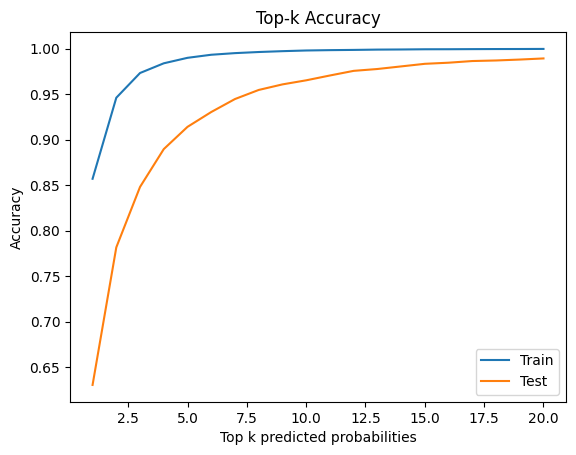

In [262]:
# Compute top-20 accuracy for train and test sets
top20_acc_train = topk_accuracy(20, probs_train, y_train_code)
top20_acc_test = topk_accuracy(20, probs_test, y_test_code)

# Plot them
plot_top20_accuracies(top20_acc_train, top20_acc_test)

In [288]:
# Save top-20 accuracy on train set
top20_accuracy_df = pd.DataFrame({'train' : top20_acc_train, 'test' : top20_acc_test})
top20_accuracy_df['model'] = 'Multinomial Logistic'
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top3acc_path + '/logistic.csv')

# Display top-3 accuracy
display(top20_accuracy_df[:3])

,model,train,test
0,Multinomial Logistic,0.856952,0.630399
1,Multinomial Logistic,0.946023,0.781581
2,Multinomial Logistic,0.973193,0.848003


# Support Vector Machine

In [29]:
from sklearn.svm import LinearSVC, SVC

In [30]:
classifier = LinearSVC(  multi_class='ovr', dual='auto', max_iter=100)

hyper_param = {'C':[0.01, 0.1, 1]}

# GridSearchCV - stratifiedKFold is used by default
# score (on CV sets) to compare between models: 'accuracy' instead of 'neg_log_loss'
# because LinearSVC does not provide predicted probabilities to compute 'neg_log_loss' 
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'accuracy',
                       n_jobs = 16,
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)


GridSearchCV(cv=5, estimator=LinearSVC(dual='auto', max_iter=100), n_jobs=16,
             param_grid={'C': [0.01, 0.1, 1]}, scoring='accuracy')

In [31]:
# Show best hyper parameters
grid_cv.best_params_

{'C': 0.01}

In [32]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([4291.37868938, 6222.12897968, 6410.99633355]),
 'std_fit_time': array([38.30407597, 28.61077722, 29.77959683]),
 'mean_score_time': array([0.29341321, 0.17968311, 0.10111609]),
 'std_score_time': array([0.03305454, 0.02247985, 0.01442052]),
 'param_C': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.59384197, 0.52750736, 0.50124519]),
 'split1_test_score': array([0.59474757, 0.53169572, 0.49909441]),
 'split2_test_score': array([0.58677686, 0.51952904, 0.49066002]),
 'split3_test_score': array([0.59006   , 0.52235933, 0.49269784]),
 'split4_test_score': array([0.58790898, 0.52315182, 0.48624476]),
 'mean_test_score': array([0.59066708, 0.52484865, 0.49398844]),
 'std_test_score': array([0.00315721, 0.00427376, 0.00550345]),
 'rank_test_score': array([1, 2, 3])}

In [306]:
# Save best model using pickle 
with open(model_path + '/linearsvc.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)

# load model
with open(model_path + '/linearsvc.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate performance

To generate predicted probabilities, we will apply soft-max activation to the confidence scores predicted by Linear SVC.

In [307]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

# Predit confidence score --> to be converted to probabilities
confidence_score_train = clf.decision_function(X_train_scale)

# Compute predicted probabilities after softmax
probs_train = np.zeros_like(confidence_score_train)

for i, j in enumerate(confidence_score_train): 
    probs_train[i]= softmax(j)

Train accuracy score: 0.8950800371317952


In [308]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

# Predit confidence score --> to be converted to probabilities
confidence_score_test = clf.decision_function(X_test_scale)

# Compute predicted probabilities after softmax
probs_test = np.zeros_like(confidence_score_test)

for i, j in enumerate(confidence_score_test): 
    probs_test[i]= softmax(j)

Test accuracy score: 0.597799511002445


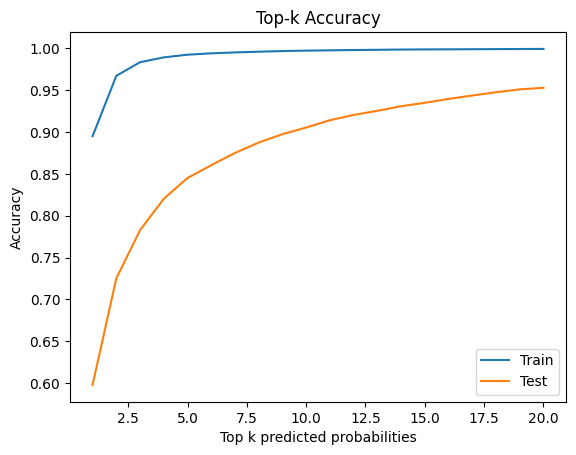

In [309]:
# Compute top-20 accuracy for train and test sets
top20_acc_train = topk_accuracy(20, probs_train, y_train_code)
top20_acc_test = topk_accuracy(20, probs_test, y_test_code)

# Plot them
plot_top20_accuracies(top20_acc_train, top20_acc_test)

In [310]:
# Save top-20 accuracy on train set
top20_accuracy_df = pd.DataFrame({'train' : top20_acc_train, 'test' : top20_acc_test})
top20_accuracy_df['model'] = 'Linear SVC'
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top3acc_path + '/linearsvc.csv')

# Display top-3 accuracy
display(top20_accuracy_df[:3])

,model,train,test
0,Linear SVC,0.895080,0.597800
1,Linear SVC,0.967261,0.725143
2,Linear SVC,0.983517,0.782804


# Random Forest

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
classifier = RandomForestClassifier(random_state = 614, 
                                    max_samples=round(0.5*len(y_train_code)), 
                                    class_weight='balanced', 
                                    n_jobs = 16)



hyper_param = {'max_depth':[5, 10, 15], 'n_estimators':[500, 750, 1000]}

# GridSearchCV - stratifiedKFold is used by default
# score (on CV sets) to compare between models: 'neg_log_loss' (cross entropy)
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'neg_log_loss',
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_samples=22084, n_jobs=16,
                                              random_state=614),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [500, 750, 1000]},
             scoring='neg_log_loss')

In [46]:
# Show best hyper parameters
grid_cv.best_params_

{'max_depth': 15, 'n_estimators': 1000}

In [47]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([ 50.08609428,  74.68437462,  98.91510367,  97.74663563,
        145.3374258 , 195.45401168, 140.50382943, 209.40648713,
        275.92165928]),
 'std_fit_time': array([0.32720954, 0.29016859, 0.33375849, 0.83129642, 0.87263074,
        2.51812581, 0.3905283 , 1.06676507, 0.5299314 ]),
 'mean_score_time': array([0.59712806, 0.89998078, 1.19132476, 0.69294076, 1.03235545,
        1.43302279, 0.80233502, 1.15522342, 1.50975304]),
 'std_score_time': array([0.01884952, 0.02818834, 0.01208301, 0.02195106, 0.00979698,
        0.08877929, 0.03951709, 0.026713  , 0.02677297]),
 'param_max_depth': masked_array(data=[5, 5, 5, 10, 10, 10, 15, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500, 750, 1000, 500, 750, 1000, 500, 750, 1000],
              mask=[False, False, False, False, False, False, False, False,
    

Deeper trees seem to play a larger role in reducing the loss.

In [294]:
# Save best model using pickle 
with open(model_path + '/rf.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)

# load model
with open(model_path + '/rf.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate performance

In [295]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

# Predict probabilities for train set
probs_train = clf.predict_proba(X_train_scale)

Train accuracy score: 0.9896755496184935


In [296]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

# Predict probabilities for test set
probs_test = clf.predict_proba(X_test_scale)

Test accuracy score: 0.49898125509372454


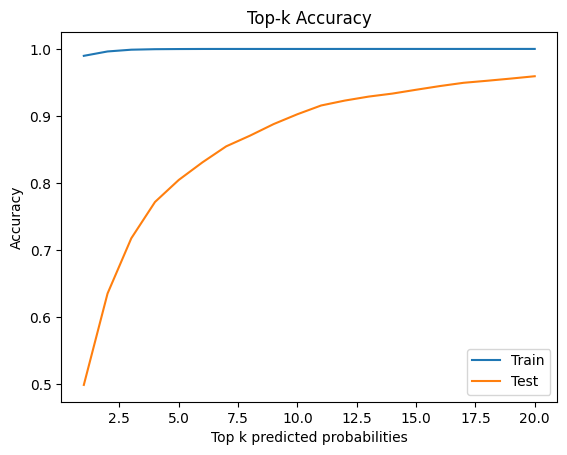

In [297]:
# Compute top-20 accuracy for train and test sets
top20_acc_train = topk_accuracy(20, probs_train, y_train_code)
top20_acc_test = topk_accuracy(20, probs_test, y_test_code)

# Plot them
plot_top20_accuracies(top20_acc_train, top20_acc_test)

In [299]:
# Save top-20 accuracy on train set
top20_accuracy_df = pd.DataFrame({'train' : top20_acc_train, 'test' : top20_acc_test})
top20_accuracy_df['model'] = 'Random Forest'
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top3acc_path + '/rf.csv')

# Display top-3 accuracy
display(top20_accuracy_df[:3])

,model,train,test
0,Random Forest,0.989676,0.498981
1,Random Forest,0.996196,0.635289
2,Random Forest,0.998823,0.717604


# XGBoost

In [24]:
from xgboost import XGBClassifier

In [7]:
# Fit model 
# Eval metric: 'log loss' (cross entropy)
XGBclf = XGBClassifier(n_estimators=1000, 
                       verbosity=1, 
                       nthread = 16,
                       eval_metric = 'mlogloss', 
                       learning_rate = 0.1,
                       early_stopping_rounds = 10)

XGBclf.fit(X_train_scale, y_train_code,
           eval_set=[(X_test_scale, y_test_code)] )

NameError: name 'X_train_scale' is not defined

In [301]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

# Predict probabilities for train set
probs_train = clf.predict_proba(X_train_scale)

Train accuracy score: 0.9999773586614441


In [302]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

# Predict probabilities for test set
probs_test = clf.predict_proba(X_test_scale)

Test accuracy score: 0.593520782396088


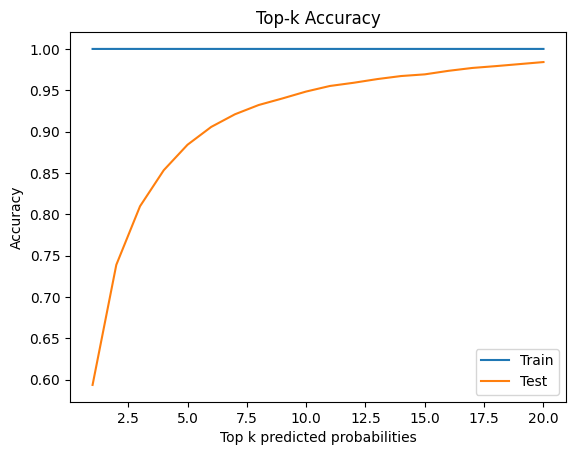

In [303]:
# Compute top-20 accuracy for train and test sets
top20_acc_train = topk_accuracy(20, probs_train, y_train_code)
top20_acc_test = topk_accuracy(20, probs_test, y_test_code)

# Plot them
plot_top20_accuracies(top20_acc_train, top20_acc_test)

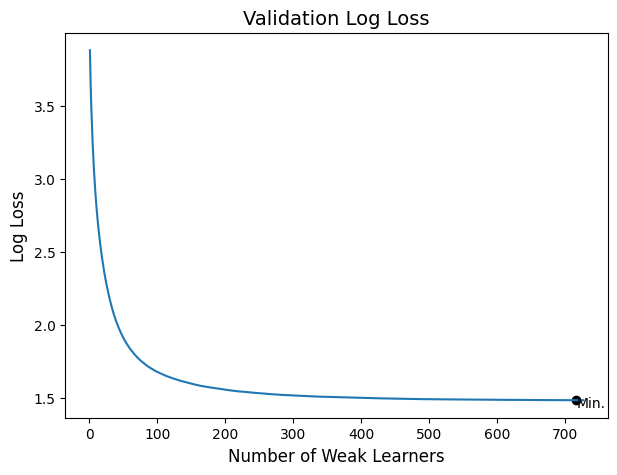

In [59]:
# Plot the Log Loss against the number of learners
plt.figure(figsize=(7,5))

plt.plot(range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1), 
         XGBclf.evals_result()['validation_0']['mlogloss'])
plt.scatter([range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1)[np.argmin(XGBclf.evals_result()['validation_0']['mlogloss'])]], 
            [np.min(XGBclf.evals_result()['validation_0']['mlogloss'])], c='k')
plt.text(range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1)[np.argmin(XGBclf.evals_result()['validation_0']['mlogloss'])], 
         np.min(XGBclf.evals_result()['validation_0']['mlogloss'])-.05, "Min.", fontsize=10)

plt.title("Validation Log Loss", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

In [300]:
# Save best model using pickle 
with open(model_path + '/xgb.pkl','wb') as f:
    pickle.dump(XGBclf, f)

# load model
with open(model_path + '/xgb.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate performance

In [301]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

# Predict probabilities for train set
probs_train = clf.predict_proba(X_train_scale)

Train accuracy score: 0.9999773586614441


In [302]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

# Predict probabilities for test set
probs_test = clf.predict_proba(X_test_scale)

Test accuracy score: 0.593520782396088


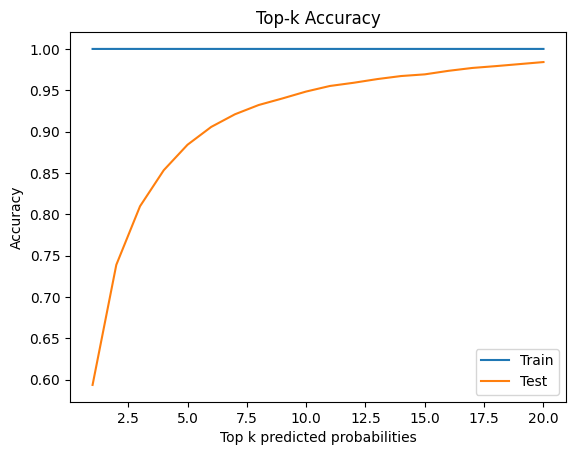

In [303]:
# Compute top-20 accuracy for train and test sets
top20_acc_train = topk_accuracy(20, probs_train, y_train_code)
top20_acc_test = topk_accuracy(20, probs_test, y_test_code)

# Plot them
plot_top20_accuracies(top20_acc_train, top20_acc_test)

In [305]:
# Save top-20 accuracy on train set
top20_accuracy_df = pd.DataFrame({'train' : top20_acc_train, 'test' : top20_acc_test})
top20_accuracy_df['model'] = 'XGBoost'
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top3acc_path + '/xgb.csv')

# Display top-3 accuracy
display(top20_accuracy_df[:3])

,model,train,test
0,XGBoost,0.999977,0.593521
1,XGBoost,1.000000,0.738794
2,XGBoost,1.000000,0.809698


# Compare across 4 algorithms with user queries

We now return top-3 best-fit styles, from which we list out top 5 wines that are most similar to the user's input by cosine similiarity.

We also compute the mean similarity score among the top 3 suggested styles. 

The similarity scores for top 3 styles and top 5 wines will help us compare modelling architects.

In [69]:
# load model - Logisitics
with open(model_path + '/logistic.pkl', 'rb') as f:
    log_model = pickle.load(f)

# load model - SVC
with open(model_path + '/linearsvc.pkl', 'rb') as f:
    svc_model = pickle.load(f)

# load model - Random Forest
with open(model_path + '/rf.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# load model
with open(model_path + '/xgb.pkl', 'rb') as f:
    xgb_model = pickle.load(f)


models_dict = {'log_model': log_model,
               'svc_model': svc_model,
               'rf_model' : rf_model, 
               'xgb_model': xgb_model}

In [70]:
# Get the train set from original data
wine_emb_train = wine_emb.loc[idx_train, :]

In [211]:
# Input - from user
# user_input = ['I want a white wine that is sweet, not bitter and have a floral note.']
user_input = ['I want a white wine that is sweet and not floral.'] 
# user_input = ['Any suggestions for a white wine that is smooth and not floral?']
# user_input = ['I want a red wine that is oaky but not spicy.'] 
# user_input = ['oaky and fruity red wine'] 
test_case = embed_model.embed_documents(user_input)
test_case_scaled = scaler.transform(test_case)


# # Input - from dataset
# user_input = wine_emb.iloc[60,:]['description']
# test_case = X_test_scale[60, :]

In [212]:
top3_styles_dict ={}
top5_wines_dict ={}

for m in models_dict.keys():
    print(m)
    if m =='svc_model':
        # Predit confidence score --> to be converted to probabilities
        confidence_score_test = models_dict[m].decision_function(test_case_scaled.reshape(1,-1))
        # Compute predicted probabilities after softmax
        pred_probs = np.zeros_like(confidence_score_test)
        for i, j in enumerate(confidence_score_test): 
            pred_probs[i]= softmax(j)
    else:
        pred_probs = models_dict[m].predict_proba(test_case_scaled.reshape(1,-1))  

    # Top-3 predicted styles
    top3styles_list = find_topk_styles(3, pred_probs)
    top3styles =  pd.DataFrame(top3styles_list, columns=['style3'])  
    top3styles['Model'] = m
   
    # Get wines in the top 3 styles from the original dataset 
    # Note: if use reviews from test set as test case, use train set for this filtering step
    narrowed_wines = wine_emb[wine_emb['style3'].isin(top3styles_list)].copy()
    # narrowed_wines = wine_emb_train[wine_emb_train['style3'].isin(top3styles_list)].copy()
    
    # Compute similarity score: cosine similarity and L2-norm similarity
    sim_cosine = np.array([ dot(r.values, test_case[0] )/(norm(r.values)*norm(test_case[0]  ) ) 
                           for i, r in narrowed_wines[narrowed_wines.columns[-n_emb_cols:]].iterrows() ], dtype='float32')
    sim_l2norm = np.array([ 1/norm( r.values - test_case[0] ) 
                           for i, r in narrowed_wines[narrowed_wines.columns[-n_emb_cols:]].iterrows() ], dtype='float32')
    
    # Find top 5 wines within the top 3 styles
    top5wines = find_topk_wines(5, narrowed_wines, sim_cosine)
    top5wines['Model'] = m
    top5wines = top5wines[[ 'Model', 'Title', 'Description', 'Similarity Score'
                            ]]
    top5_wines_dict[m] = top5wines
    
    # Compute average similarity score among top 3 styles
    narrowed_wines['sim_cosine'] = sim_cosine
    top3styles = top3styles.merge( narrowed_wines.groupby('style3').sim_cosine.mean().reset_index(), on='style3' )
    top3styles.rename(columns = {'style3': 'Style', 'sim_cosine': 'Mean Similarity Score' }, inplace=True)
    top3styles = top3styles[['Model', 'Style', 'Mean Similarity Score']]
    top3_styles_dict[m] = top3styles
 

log_model
svc_model
rf_model
xgb_model


In [213]:
# Save top 3 styles
print(f'User input:\n"{user_input}"')
print()
for m in models_dict.keys():
    print(f'Model: {m}')
    print()
    print('Top 3 styles:')
    print()
    display(top3_styles_dict[m])
    
    top3_styles_dict[m].to_csv(top3styles_path + f'/{m}.csv', index=False)

User input:
"['I want a white wine that is sweet and not floral.']"

Model: log_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,log_model,Chenin Blanc - France,0.820342
1,log_model,Portuguese White - Portugal,0.818234
2,log_model,Red Blend - California,0.809418


Model: svc_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,svc_model,Red Blend - California,0.809418
1,svc_model,Sparkling Blend - France,0.811614
2,svc_model,Pinot Noir - Anderson Valley,0.803995


Model: rf_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,rf_model,White Blend - Italy,0.813957
1,rf_model,Pinot Grigio - Italy,0.810041
2,rf_model,Grüner Veltliner - Austria,0.807587


Model: xgb_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,xgb_model,White Blend - Italy,0.813957
1,xgb_model,Portuguese White - Portugal,0.818234
2,xgb_model,Sauvignon Blanc - Chile,0.799079


In [214]:
# Save top 5 wines
print(f'User input:\n"{user_input}"')
print()
for m in models_dict.keys():
    print(f'Model: {m}')
    print()
    print('Reviews from top 5 wines:')
    print()
    # display(top5_wines_dict[m])
    for r in top5_wines_dict[m]['Description'].to_list():
        print(r,'\n')
    
    top5_wines_dict[m].to_csv(top5wines_path + f'/{m}.csv', index=False)

User input:
"['I want a white wine that is sweet and not floral.']"

Model: log_model

Reviews from top 5 wines:

A soft and easy white wine that has a lightly perfumed touch from the Moscatel in the blend. Acidity cuts the pear and peach flavors to give a fresh lift at the end. 

Sweet and simple, this soft wine has sugary berry and cola flavors. 

Soft and lightly sweet, this wine is clean and fresh. The white fruit flavors edge towards almond, and there is a refreshing green touch. The aftertaste has currants and sweetness. 

Soft and soapy, this is a simple wine without much character. It's a light, slightly sweet wine to be drunk this year. Screwcap. 

A wine that is so soft, its texture only just brushes the palate. White fruits and lemon juice give a gentle, balanced character that is light and quite ready to drink. 

Model: svc_model

Reviews from top 5 wines:

Sweet and simple, this soft wine has sugary berry and cola flavors. 

This is an elegant, silky-textured wine that doe